In [6]:
from scipy import special as sp
import numpy as np
import matplotlib.pyplot as plt

from ipynb.fs.full.mie_functions import *

In [7]:
# Import refractive index values
ref_lam_silver, ref_n_silver, ref_k_silver = import_data("McPeak_silver.csv")
m_silver = ref_n_silver + 1j * ref_k_silver # SIGN!!!!!!!!
ref_lam_gold, ref_n_gold, ref_k_gold = import_data("McPeak_gold.csv")
m_gold = ref_n_gold + 1j * ref_k_gold # SIGN!!!!!!!!

In [8]:
# Define constants
hbar = 1.054571817e-34 # [Js]   1 [au]
d_eg = 8.4783536198e-30 # 1 [au]
c = 299792458 # [m/s] / (2.187691 * (10**6)) [au]
dperm = 0.9*d_eg
r = 0.01 #micrometers

In [9]:
def rabi_frequency(x_points, y, z, refr_ind, lam_list, r, E_0 = 0.01, n = 1, lam_value = 0.36, print_vals = False):
    # Rescale coordinates to meters
    x_vals = x_points*1.0e-9 # nm --> m
    y_val = y*1.0e-9 # nm --> m
    z_val = z*1.0e-9 # nm --> m
    E_0val = E_0*5.14220675112*1e11
    # Find refractive index at wavelength LAM_VALUE
    index = np.where(lam_list == lam_value)
    m_value = refr_ind[index]  
    #Rescale input parameters to meters
    lam_vals = lam_list * 1e-6 # micrometers --> m
    lam_val = lam_value * 1e-6 # micrometers --> m
    rad = r * 1e-6 # micrometers --> m
    # Build arrays of points and scattered fields
    E = np.zeros_like(x_vals)
    ind = 0
    for i in x_vals:
        if i**2 + y_val**2 < rad**2:
             E[ind] = 0
        else:
            E[ind] += E_0val * scattered_field_absolute(i, y_val, z_val, refr_ind, lam_vals, rad, lam_val, n = 1)[0] # in V/m
        ind += 1

    w = 2*np.pi*c/lam_val
    omega_np = E*d_eg/hbar
    kappa = E*dperm/(hbar * w)
    if print_vals:
        print('w', w)
        print('E-field', E)
        print('E/E0', E/E_0val)        
        print('kappa', kappa)
    J_factor = sp.jv(0, kappa) #2*sp.jv(1,kappa)/kappa 
    omega = omega_np*J_factor #*sp.jv(0, kappa) # Multiply by 2?
    return J_factor, E, omega_np, omega

/home/jovyan/pdms/mie_functions.ipynb:364: RuntimeWarning: divide by zero encountered in scalar divide
  {


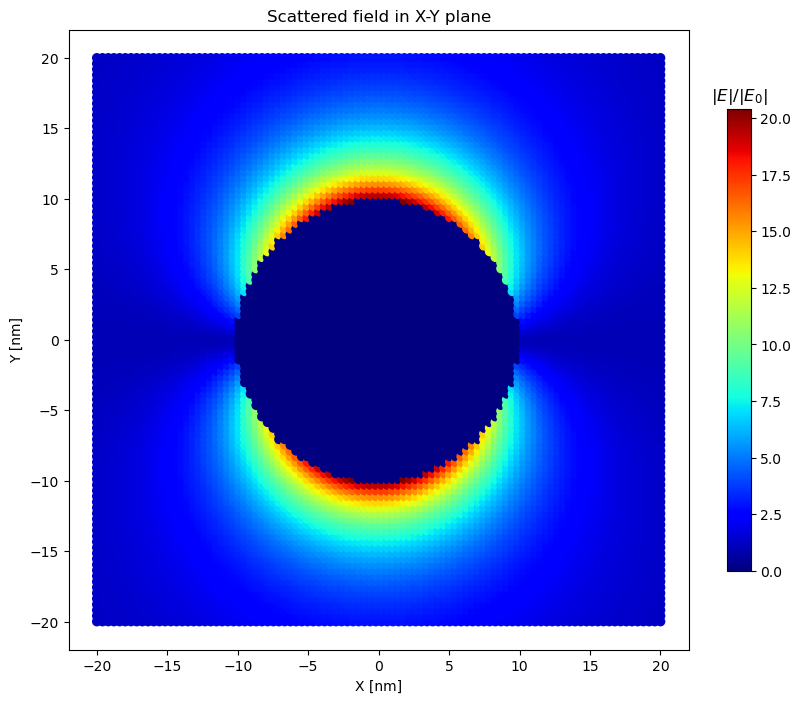

('At incoming wavelength of 360000000.0 nm',
 'Maximum scattered field = 20.422256542018516 E_0')

<Figure size 640x480 with 0 Axes>

In [10]:
#x_arr = np.linspace(-1.0,1.0,100) #nm
#y_arr = np.linspace(-11.0,-10.0,100)
x_arr = np.linspace(-20.0,20.0,100) #nm
y_arr = np.linspace(-20.0,20.0,100)
lam = 0.55
m = m_gold[np.where(ref_lam_gold == 0.55)]
#plot_scattered_field(y_arr, x_arr, 0.0, m_gold, lam_list = ref_lam_gold, lam_value = lam, r = r, filename = 'defaultFile.txt', n = 1)

plot_scattered_field(y_arr, x_arr, 0.0, m_silver, lam_list = ref_lam_silver, lam_value = 0.36, r = r, filename = 'defaultFile.txt', n = 1)

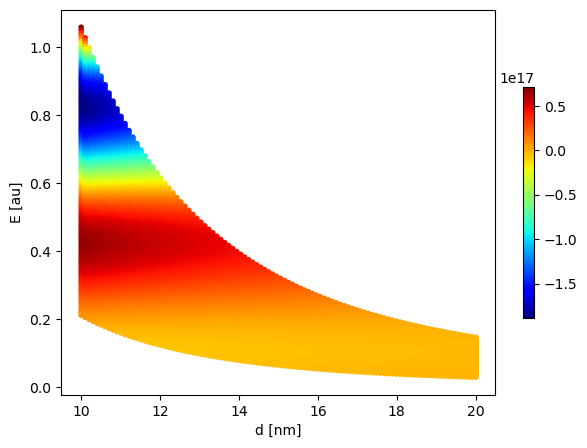

In [28]:
def rabi_colorbar(x_points, y, z, refr_ind, lam_list, r, E0s = np.linspace(0.05, 0.01, 100), n = 1, lam_value = 0.36, \
                  print_vals = False, correction = True):
    #colors = np.zeros_like(E0s, dtype = 'float')
    y_vals = np.ones_like(x_points)*y
    r_arr = np.sqrt(x_arr**2 + y_vals**2)
    Evals = np.zeros((len(x_points), len(E0s)), dtype = 'float')
    rs = np.zeros((len(x_points), len(E0s)), dtype = 'float')
    colors = np.zeros((len(x_points), len(E0s)), dtype = 'float')

    ind = 0
    for j in E0s:
        J_factor, E, omega_np, omega = rabi_frequency(x_points = x_points, y = y, z = z, E_0 = j, refr_ind = refr_ind, \
                                           lam_list = lam_list, r = r, n = n, lam_value = lam_value, print_vals = False)
        Evals[:,ind] = E / (5.14220675112*1e11)
        rs[:,ind] = r_arr
        if correction:
            colors[:,ind] = np.gradient(omega_np, r_arr/(r*1e3))
        else:
            colors[:,ind] = np.gradient(omega, r_arr/(r*1e3))
        ind += 1
        
    fig, ax = plt.subplots(1,1, figsize = (7, 5))
    plt.scatter(rs, Evals, c=colors, cmap='jet', label = 'full', marker = '.')
    ax.set_ylabel('E [au]')
    ax.set_xlabel('d [nm]')
    #plt.scatter(colors, E+0.1*E, c=colors, cmap='jet', label = 'np')
    cbar = plt.colorbar(shrink = 0.6) #, ticks = [-2.5e16,-2.0e16,-1.5e16,-1e16,-0.5e16,0.0,0.5e16])
    #ax.legend()

x_arr = np.linspace(1.0, 2.0, 100) * 10 #np.linspace(10.0,90.0,100) #*r*1e3 #nm
y_arr = np.array([0.0]) #np.linspace(0.0,90.0,100) #nm np.array([0.0]) #
rabi_colorbar(x_points = x_arr, y = y_arr[0], z = 0.0, refr_ind = m_silver, lam_list = ref_lam_silver, \
              r = r, n = 1, lam_value = 0.36, print_vals = False, correction = False)

In [26]:
x_arr = np.linspace(1.0, 2.0, 100) * 10 #np.linspace(10.0,90.0,100) #*r*1e3 #nm
y_arr = np.array([0.0]) #np.linspace(0.0,90.0,100) #nm np.array([0.0]) #
J_factor, E, omega_np, omega = rabi_frequency(x_points = x_arr, y = y_arr[0], z = 0.0, refr_ind = m_silver, \
                                           lam_list = ref_lam_silver, r = r, n = 1, lam_value = 0.36, E_0 = 0.01, print_vals = False)

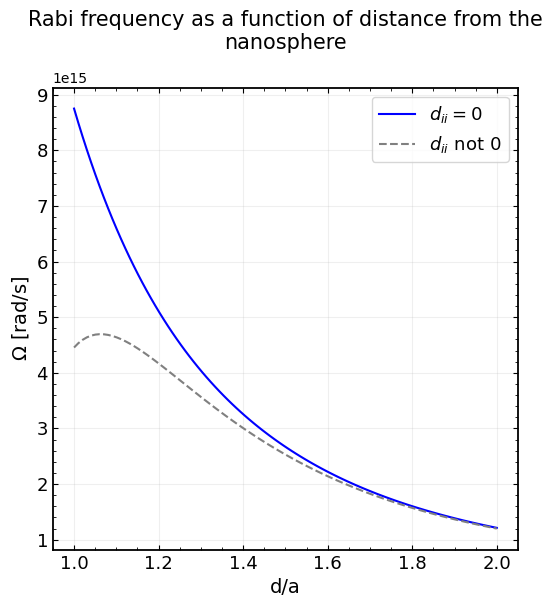

In [27]:
y_vals = np.ones_like(x_arr)*y_arr[0]
r_arr = np.sqrt(x_arr**2 + y_vals**2)
general_plot_style(x = [r_arr/(r*1e3), r_arr/(r*1e3)], y = [omega_np, omega], legendlabels = ['$d_{ii} = 0$', '$d_{ii}$ not $0$'], colors = ['blue', 'grey'], \
                   ls = ['solid', '--'], ylims = None, xlabel = 'd/a', ylabel = '$\Omega$ [rad/s]', \
                   title = 'Rabi frequency as a function of distance from the nanosphere', figsize = [6,6])

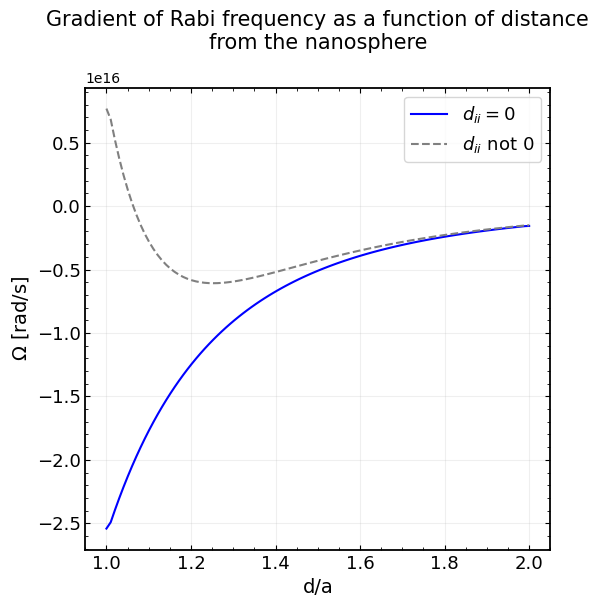

In [16]:
general_plot_style(x = [r_arr/(r*1e3), r_arr/(r*1e3)], y = [np.gradient(omega_np, r_arr/(r*1e3)), np.gradient(omega, r_arr/(r*1e3))], \
                   legendlabels = ['$d_{ii} = 0$', '$d_{ii}$ not $0$'], colors = ['blue', 'grey'], \
                   ls = ['solid', '--'], ylims = None, xlabel = 'd/a', ylabel = '$\Omega$ [rad/s]', \
                   title = 'Gradient of Rabi frequency as a function of distance from the nanosphere', figsize = [6,6], \
                   filename = 'rabi_frequency.jpg', savefig = True)

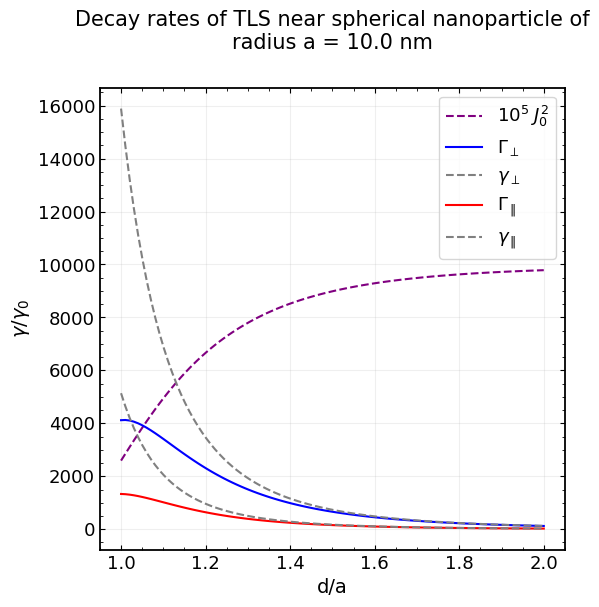

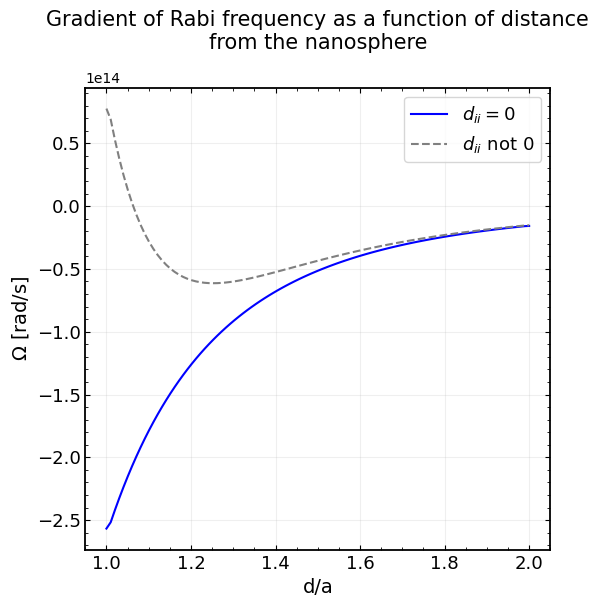

In [10]:
a = 10e-9  # radius of the sphere in meters (10 nm)
lam = 0.36  # emission wavelength in meters (360 nm)
index = np.where(ref_lam_silver == lam)
mval = m_silver[index][0]
dpoints = x_arr*1e-9 #[in m] #np.linspace(1.0, 2.0, 100) * a
A_list, B_list, gamma_norm, gamma_tang, gamma_norm_rad, gamm_tang_rad = gamma_factors(dpoints, mval, lam*1e-6, a, n = 1, order = 5, \
                                                                                      plot = False)
general_plot_style(x = [dpoints/a,dpoints/a,dpoints/a,dpoints/a,dpoints/a], y = [(10000*J_factor**2),(J_factor**2)*gamma_norm, \
                   gamma_norm, (J_factor**2)*gamma_tang, gamma_tang], figsize = [6,6], \
                   legendlabels = ['$10^5 \; J_0^2$','$\Gamma_{\perp}$', '$\gamma_{\perp}$', '$\Gamma_{\, \|}$', '$\gamma_{\, \|}$'], \
                   colors = ['purple', 'blue', 'grey', 'red', 'grey'], xlabel = 'd/a', ylabel = '$\gamma / \gamma_0$', \
                   ls = ['--','solid', '--', 'solid', '--'], \
                   title = f'Decay rates of TLS near spherical nanoparticle of radius a = {a*10**9} nm', \
                   filename = 'decay_rates.jpg', savefig = True)
general_plot_style(x = [r_arr/(r*1e3), r_arr/(r*1e3)], y = [np.gradient(omega_np), np.gradient(omega)], \
                   legendlabels = ['$d_{ii} = 0$', '$d_{ii}$ not $0$'], colors = ['blue', 'grey'], \
                   ls = ['solid', '--'], ylims = None, xlabel = 'd/a', ylabel = '$\Omega$ [rad/s]', \
                   title = 'Gradient of Rabi frequency as a function of distance from the nanosphere', figsize = [6,6], \
                   filename = 'rabi_frequency.jpg', savefig = True)